## Dependencies

In [1]:
import math, os, re, warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import optimizers, applications, Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

### TPU configuration

In [2]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [3]:
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
WARMUP_EPOCHS = 3
WARMUP_LEARNING_RATE = 1e-4 * strategy.num_replicas_in_sync
EPOCHS = 20
LEARNING_RATE = 3e-5 * strategy.num_replicas_in_sync
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
N_CLASSES = 104
ES_PATIENCE = 6
RLROP_PATIENCE = 3
DECAY_DROP = 0.3

model_path = 'DenseNet201_%sx%s.h5' % (HEIGHT, WIDTH)

GCS_PATH = KaggleDatasets().get_gcs_path() + '/tfrecords-jpeg-%sx%s' % (HEIGHT, WIDTH)

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 
    'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 
    'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 
    'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 
    'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 
    'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 
    'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 
    'carnation', 'garden phlox', 'love in the mist', 'cosmos',  'alpine sea holly', 
    'ruby-lipped cattleya', 'cape flower', 'great masterwort',  'siam tulip', 
    'lenten rose', 'barberton daisy', 'daffodil',  'sword lily', 'poinsettia', 
    'bolero deep blue',  'wallflower', 'marigold', 'buttercup', 'daisy', 
    'common dandelion', 'petunia', 'wild pansy', 'primula',  'sunflower', 
    'lilac hibiscus', 'bishop of llandaff', 'gaura',  'geranium', 'orange dahlia', 
    'pink-yellow dahlia', 'cautleya spicata',  'japanese anemone', 'black-eyed susan', 
    'silverbush', 'californian poppy',  'osteospermum', 'spring crocus', 'iris', 
    'windflower',  'tree poppy', 'gazania', 'azalea', 'water lily',  'rose', 
    'thorn apple', 'morning glory', 'passion flower',  'lotus', 'toad lily', 
    'anthurium', 'frangipani',  'clematis', 'hibiscus', 'columbine', 'desert-rose', 
    'tree mallow', 'magnolia', 'cyclamen ', 'watercress',  'canna lily', 
    'hippeastrum ', 'bee balm', 'pink quill',  'foxglove', 'bougainvillea', 
    'camellia', 'mallow',  'mexican petunia',  'bromelia', 'blanket flower', 
    'trumpet creeper',  'blackberry lily', 'common tulip', 'wild rose']

In [4]:
# Datasets utility functions
AUTO = tf.data.experimental.AUTOTUNE # instructs the API to read from multiple files if available.

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    image = tf.image.random_saturation(image, lower=0, upper=2, seed=seed)
#     image = tf.image.random_contrast(image, lower=.8, upper=2, seed=seed)
#     image = tf.image.random_brightness(image, max_delta=.2, seed=seed)
    image = tf.image.random_crop(image, size=[int(HEIGHT*.8), int(WIDTH*.8), CHANNELS], seed=seed)

    return image, label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_training_dataset_preview(ordered=True):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [5]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()
    
# Visualize model predictions
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# EDA

## About the datasets

In [6]:
# Train data
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
train_dataset = get_training_dataset_preview(ordered=True)
y_train = next(iter(train_dataset.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()
print('Number of training images %d' % NUM_TRAINING_IMAGES)

# Validation data
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
valid_dataset = get_validation_dataset(ordered=True)
y_valid = next(iter(valid_dataset.unbatch().map(lambda image, label: label).batch(NUM_VALIDATION_IMAGES))).numpy()
print('Number of validation images %d' % NUM_VALIDATION_IMAGES)

# Test data
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Number of test images %d' % NUM_TEST_IMAGES)
test_dataset = get_test_dataset(ordered=True)

Number of training images 12753
Number of validation images 3712
Number of test images 7382


## First let's look at some samples from each set

### Train samples

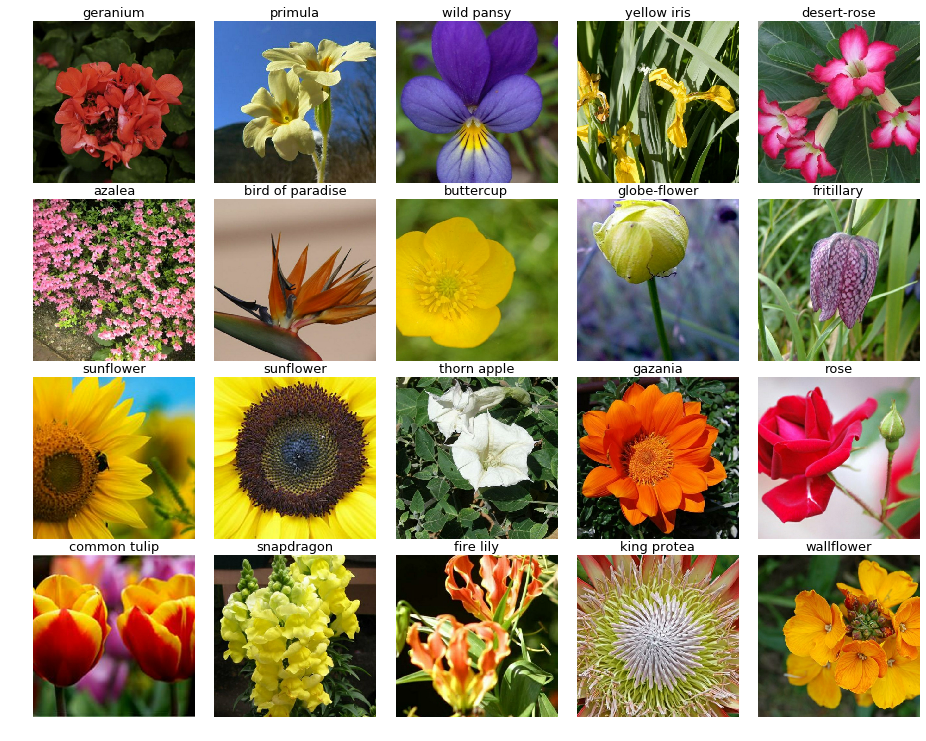

In [7]:
display_batch_of_images(next(iter(train_dataset.unbatch().batch(20))))

### Validation samples

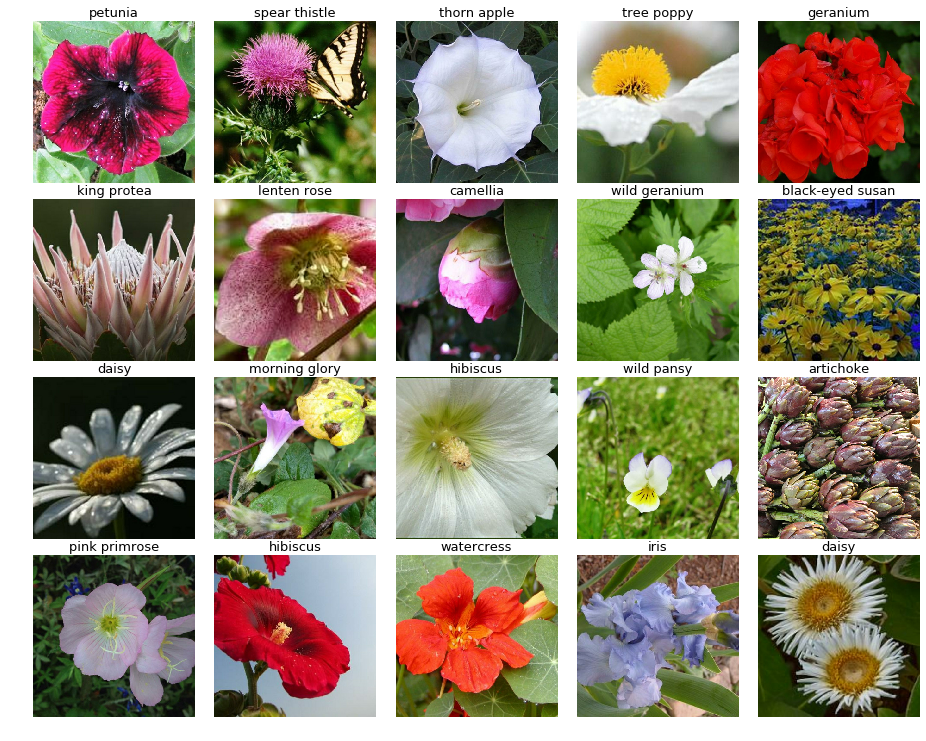

In [8]:
display_batch_of_images(next(iter(valid_dataset.unbatch().batch(20))))

### Test samples

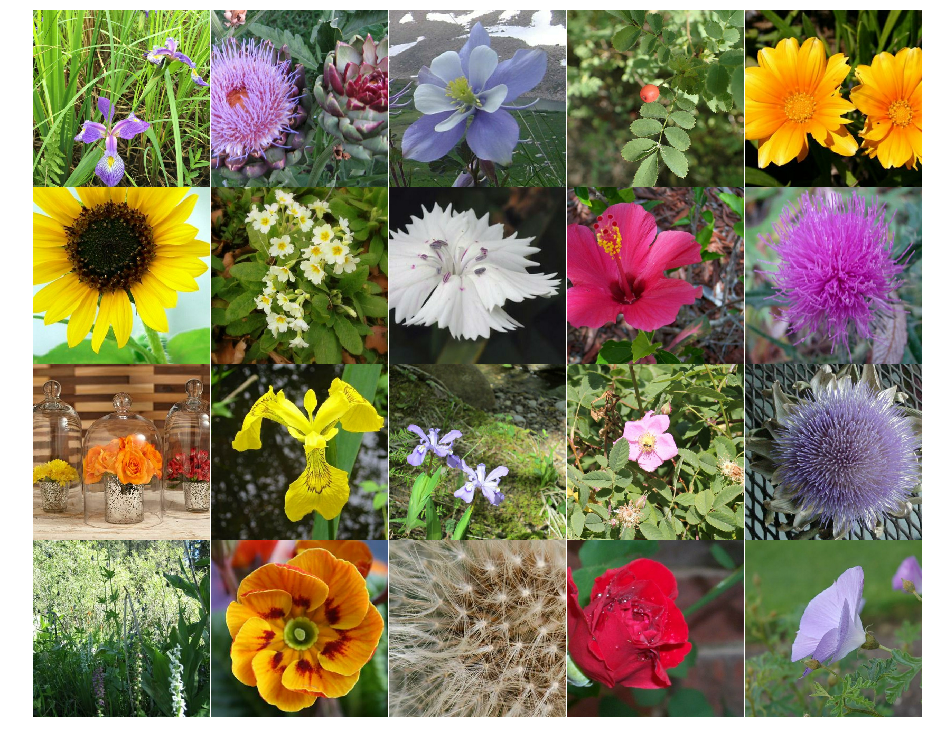

In [9]:
display_batch_of_images(next(iter(test_dataset.unbatch().batch(20))))

The important thing here is that the image quality seems to be very consistent over the datasets, this will make things easier for the model to generalize, also dataset seems to be pretty diverse in terms of flower types, but we will look into this in more details.

## Label distribution

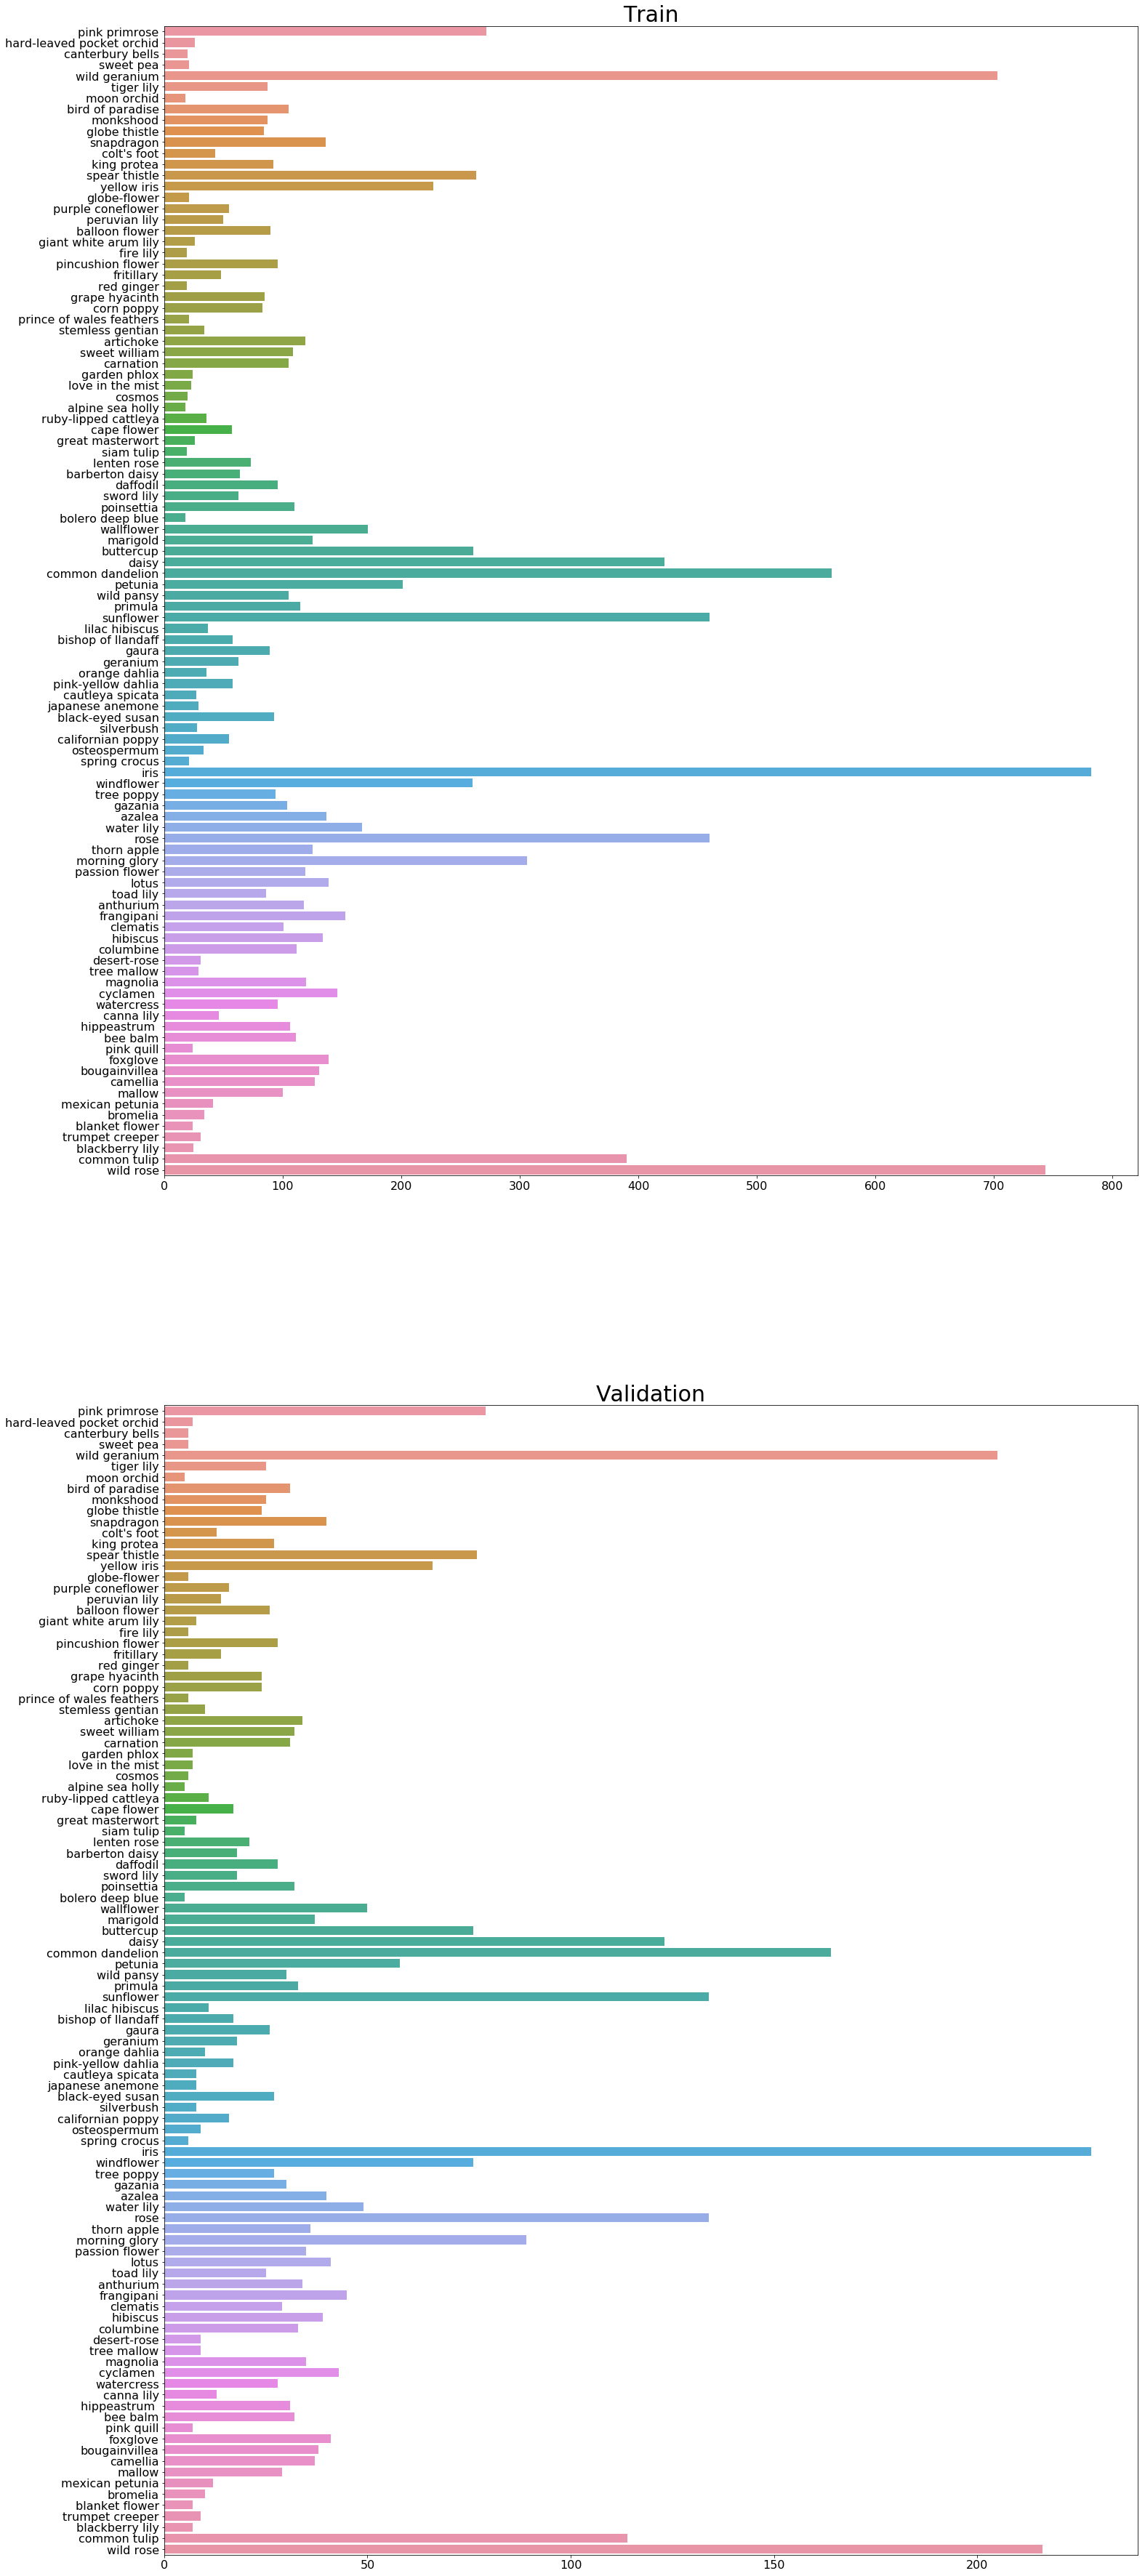

In [10]:
train_agg = np.asarray([[label, (y_train == index).sum()] for index, label in enumerate(CLASSES)])
valid_agg = np.asarray([[label, (y_valid == index).sum()] for index, label in enumerate(CLASSES)])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 64))

ax1 = sns.barplot(x=train_agg[...,1], y=train_agg[...,0], order=CLASSES, ax=ax1)
ax1.set_title('Train', fontsize=30)
ax1.tick_params(labelsize=16)

ax2 = sns.barplot(x=valid_agg[...,1], y=valid_agg[...,0], order=CLASSES, ax=ax2)
ax2.set_title('Validation', fontsize=30)
ax2.tick_params(labelsize=16)

plt.show()

As we can see the datasets are largely unbalanced, but the train and validation sets have a similar distribution.

# Model

In [11]:
def create_model(input_shape, N_CLASSES):
    base_model = applications.DenseNet201(weights='imagenet', 
                                          include_top=False,
                                          input_shape=input_shape)

    base_model.trainable = False # Freeze layers
    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    
    return model

# Warmup top layers

In [12]:
with strategy.scope():
    model = create_model((None, None, CHANNELS), N_CLASSES)
    
metric_list = ['sparse_categorical_accuracy']

optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metric_list)
model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 199,784
Non-trainable params: 18,321,984
_________________________________________________________________


In [13]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
warmup_history = model.fit(x=get_training_dataset(), 
                           steps_per_epoch=STEPS_PER_EPOCH, 
                           validation_data=get_validation_dataset(),
                           epochs=WARMUP_EPOCHS, 
                           verbose=2).history

Train for 199 steps
Epoch 1/3
199/199 - 132s - loss: 3.2248 - sparse_categorical_accuracy: 0.3053 - val_loss: 3.3598 - val_sparse_categorical_accuracy: 0.1940
Epoch 2/3
199/199 - 43s - loss: 2.0646 - sparse_categorical_accuracy: 0.5741 - val_loss: 3.0891 - val_sparse_categorical_accuracy: 0.2823
Epoch 3/3
199/199 - 43s - loss: 1.5830 - sparse_categorical_accuracy: 0.6168 - val_loss: 2.9832 - val_sparse_categorical_accuracy: 0.3017


### Learning rate schedule

Learning rate schedule: 1e-08 to 0.00024 to 7.73e-06


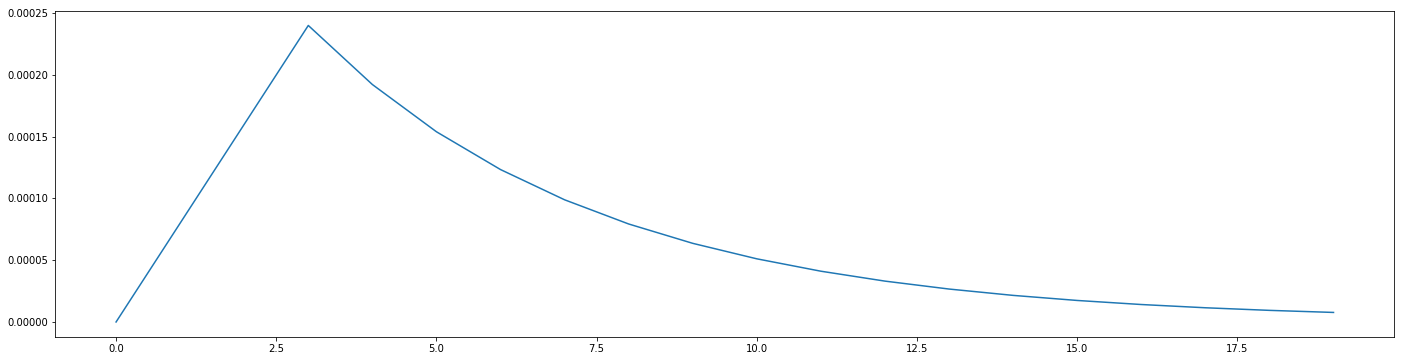

In [14]:
LR_START = 0.00000001
LR_MIN = 0.000001
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

fig, ax = plt.subplots(figsize=(24, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Fine-tune all layers

In [15]:
for layer in model.layers:
    layer.trainable = True # Unfreeze layers

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)
lr_callback = LearningRateScheduler(lrfn, verbose=1)

callback_list = [checkpoint, es, lr_callback]
class_weights = class_weight.compute_class_weight('balanced', [x for x in range(len(CLASSES))], y_train)

optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=metric_list)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               199784    
Total params: 18,521,768
Trainable params: 18,292,712
Non-trainable params: 229,056
_________________________________________________________________


In [16]:
history = model.fit(x=get_training_dataset(), 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_data=get_validation_dataset(),
                    callbacks=callback_list,
                    class_weight=class_weights,
                    epochs=EPOCHS, 
                    verbose=2).history

Train for 199 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-08.
Epoch 1/20
199/199 - 296s - loss: 1.4545 - sparse_categorical_accuracy: 0.6652 - val_loss: 1.7511 - val_sparse_categorical_accuracy: 0.5733

Epoch 00002: LearningRateScheduler reducing learning rate to 8.000666666666666e-05.
Epoch 2/20
199/199 - 83s - loss: 0.8524 - sparse_categorical_accuracy: 0.7990 - val_loss: 0.5271 - val_sparse_categorical_accuracy: 0.8642

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00016000333333333333.
Epoch 3/20
199/199 - 84s - loss: 0.5590 - sparse_categorical_accuracy: 0.8593 - val_loss: 0.4401 - val_sparse_categorical_accuracy: 0.8858

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00024.
Epoch 4/20
199/199 - 71s - loss: 0.4463 - sparse_categorical_accuracy: 0.8882 - val_loss: 0.5737 - val_sparse_categorical_accuracy: 0.8276

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0001922.
Epoch 5/20
199/199 - 82s - loss: 0.2937

## Model loss graph

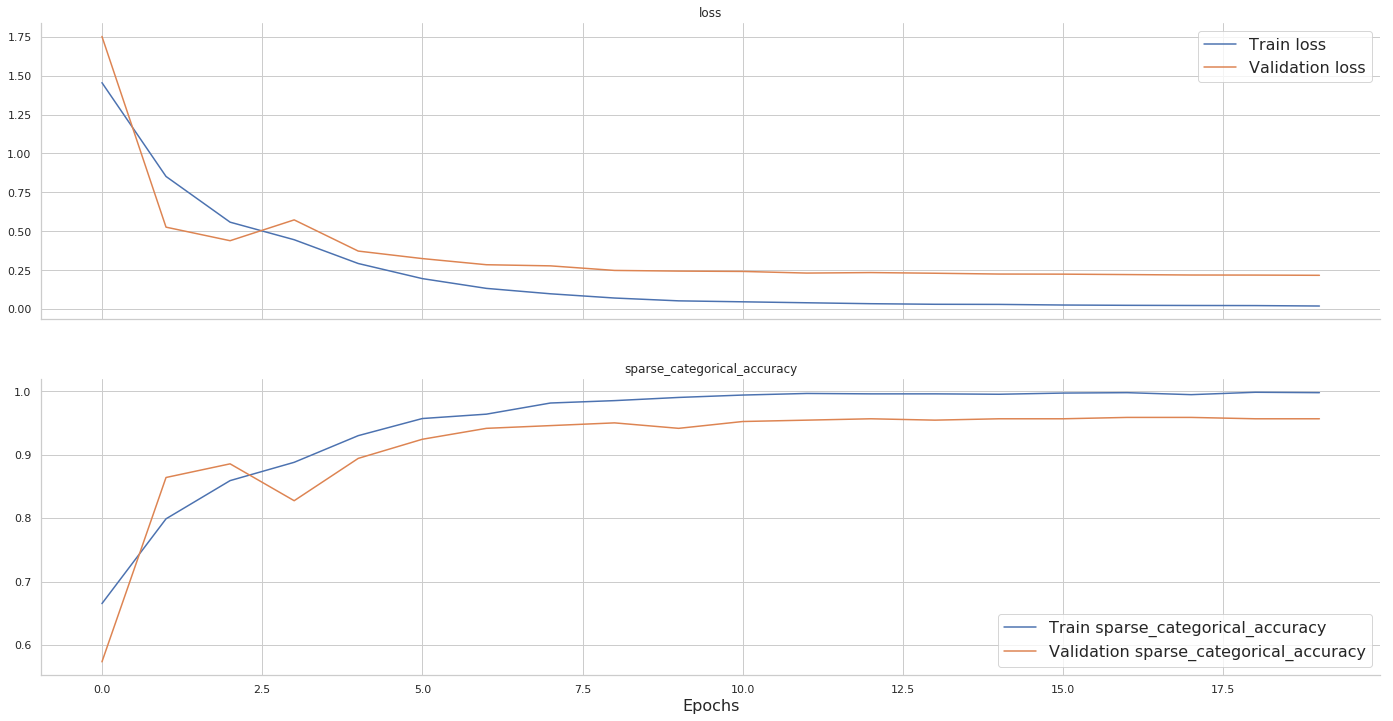

In [17]:
def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(24, 12))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'sparse_categorical_accuracy'])

# Model evaluation

## Train set

In [18]:
x_train = train_dataset.map(lambda image, label: image)
train_preds = model.predict(x_train)
train_preds = np.argmax(train_preds, axis=-1)

print(classification_report(y_train, train_preds, target_names=CLASSES))

                           precision    recall  f1-score   support

            pink primrose       1.00      1.00      1.00       272
hard-leaved pocket orchid       1.00      1.00      1.00        26
         canterbury bells       1.00      1.00      1.00        20
                sweet pea       1.00      1.00      1.00        21
            wild geranium       1.00      1.00      1.00       703
               tiger lily       1.00      1.00      1.00        87
              moon orchid       1.00      1.00      1.00        18
         bird of paradise       1.00      1.00      1.00       105
                monkshood       1.00      1.00      1.00        87
            globe thistle       1.00      1.00      1.00        84
               snapdragon       1.00      1.00      1.00       136
              colt's foot       1.00      1.00      1.00        43
              king protea       1.00      0.99      0.99        92
            spear thistle       1.00      1.00      1.00     

## Validation set

In [19]:
x_valid = valid_dataset.map(lambda image, label: image)
valid_preds = model.predict(x_valid)
valid_preds = np.argmax(valid_preds, axis=-1)

print(classification_report(y_valid, valid_preds, target_names=CLASSES))

                           precision    recall  f1-score   support

            pink primrose       1.00      0.96      0.98        79
hard-leaved pocket orchid       1.00      1.00      1.00         7
         canterbury bells       1.00      1.00      1.00         6
                sweet pea       1.00      0.33      0.50         6
            wild geranium       0.95      0.99      0.97       205
               tiger lily       0.92      0.92      0.92        25
              moon orchid       1.00      1.00      1.00         5
         bird of paradise       1.00      0.94      0.97        31
                monkshood       1.00      0.96      0.98        25
            globe thistle       0.92      1.00      0.96        24
               snapdragon       1.00      0.97      0.99        40
              colt's foot       1.00      0.92      0.96        13
              king protea       1.00      0.96      0.98        27
            spear thistle       0.92      0.99      0.95     

# Confusion matrix

## Train

I have split confusion matrices into 3 parts to make it clearer, the first plot has classes 1 from 34, the second plot 35 to 69 and the third has the remaining ones.

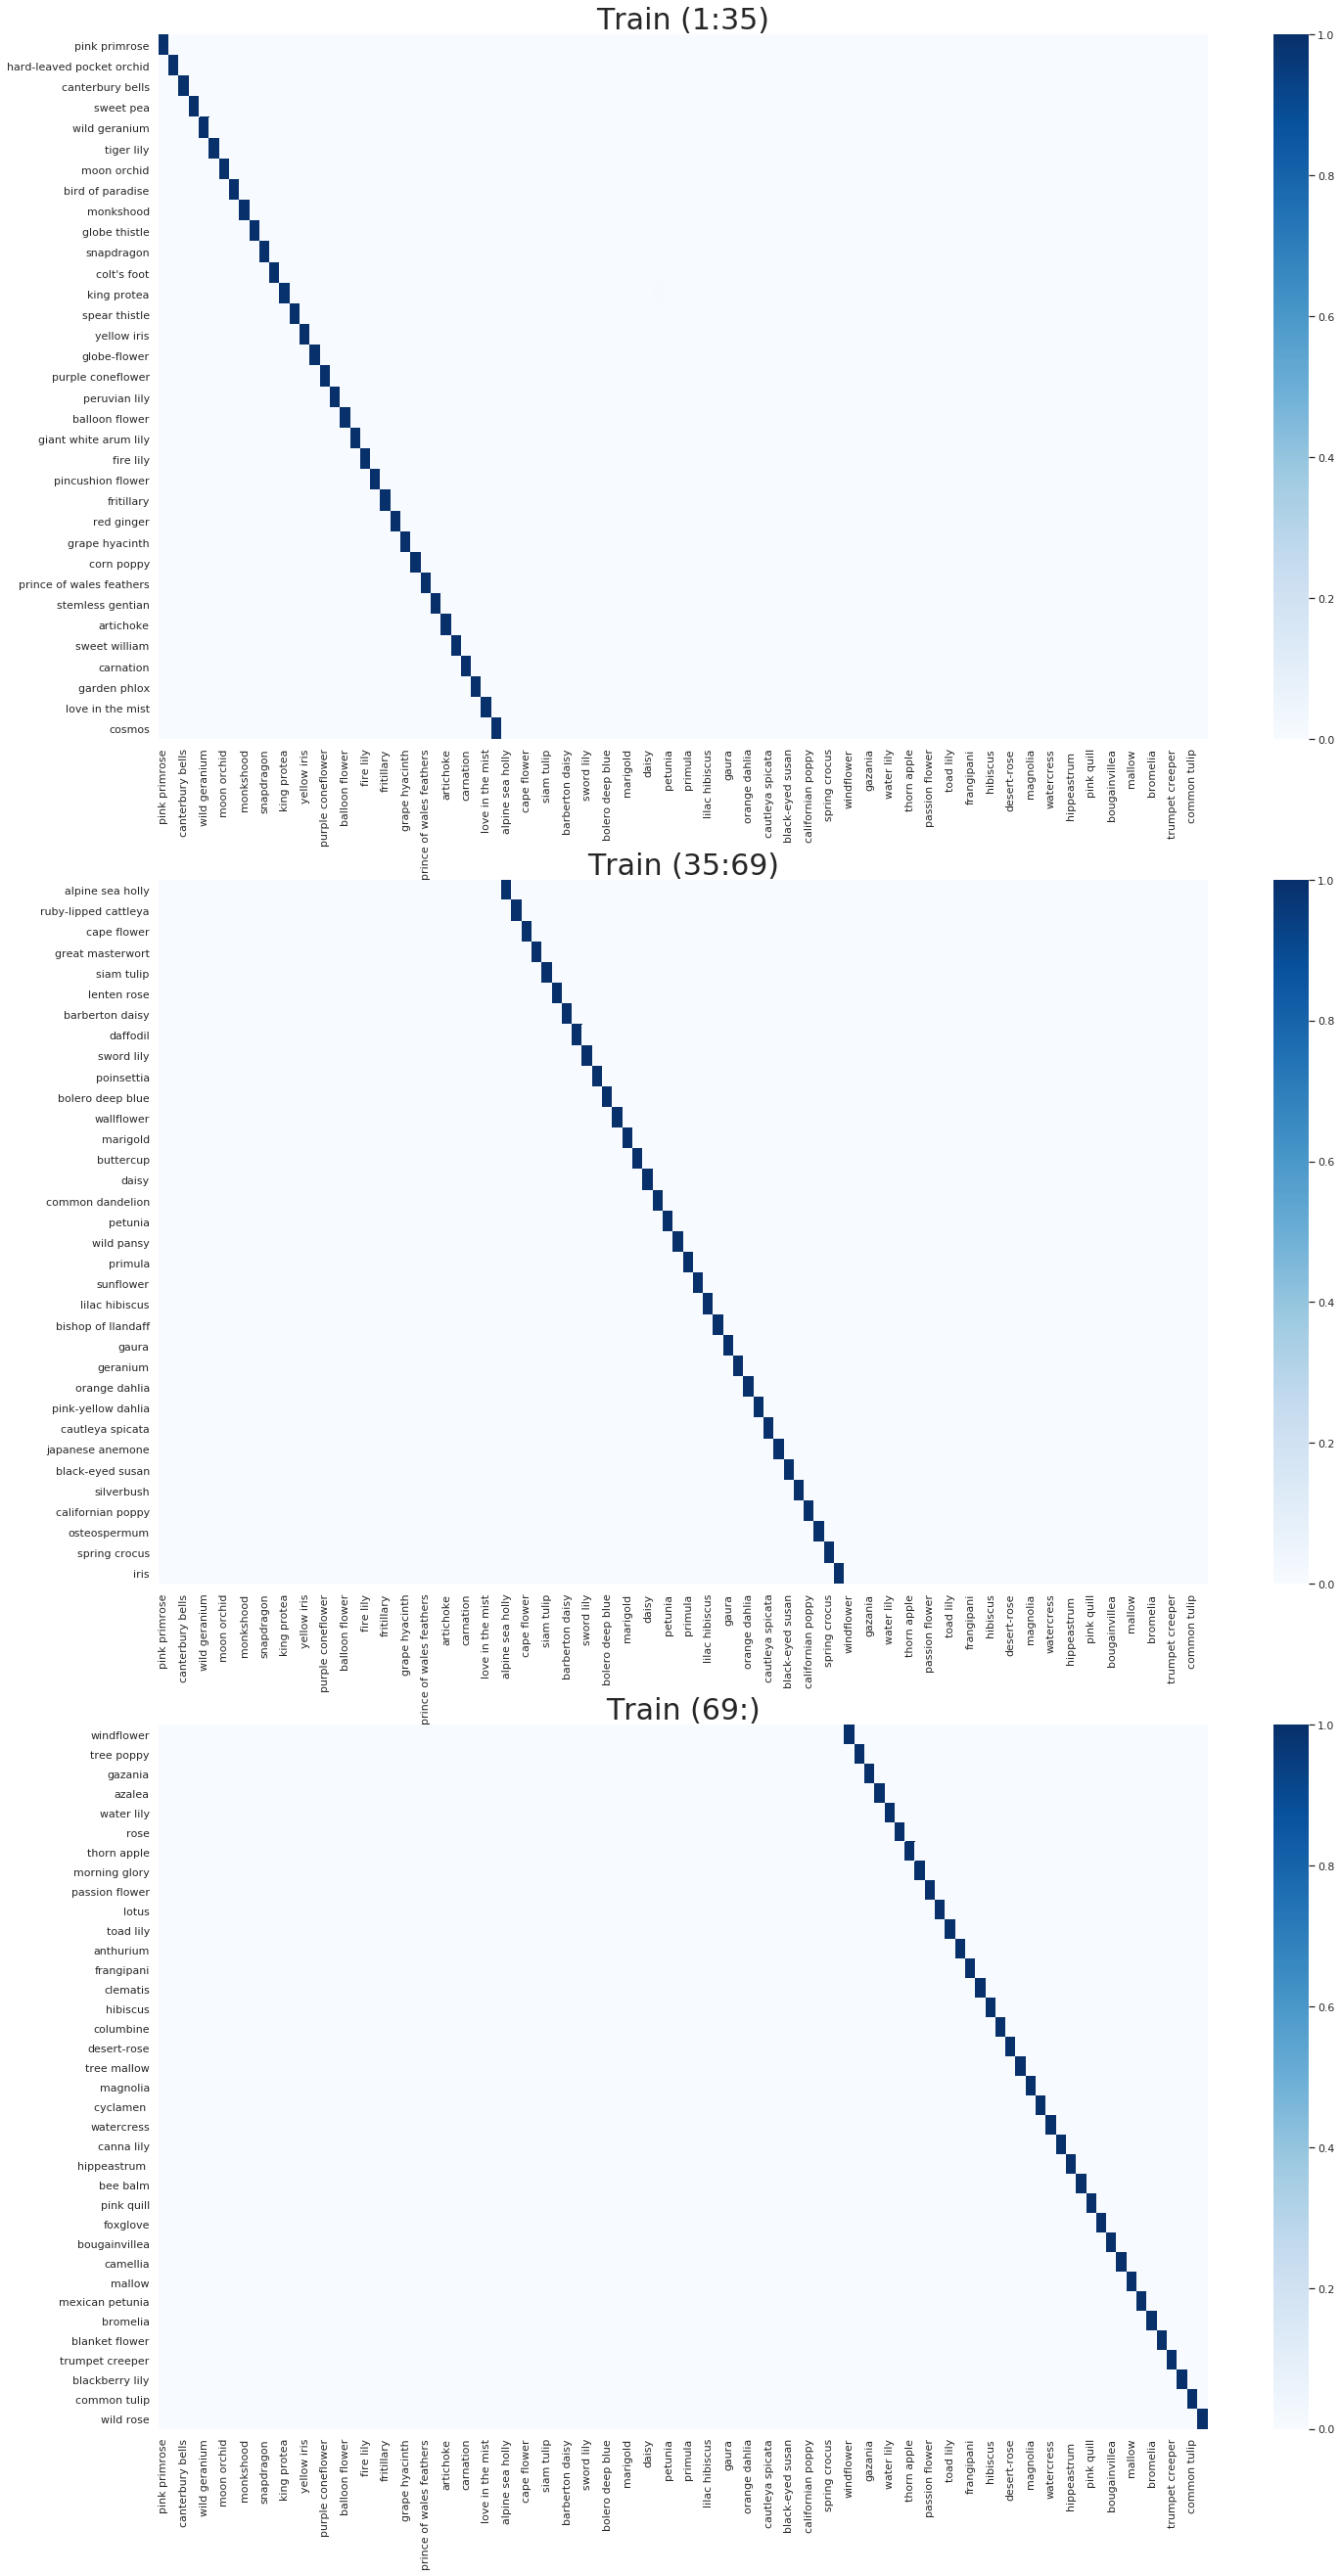

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 45))

train_cfn_matrix = confusion_matrix(y_train, train_preds, labels=range(len(CLASSES)))
train_cfn_matrix = (train_cfn_matrix.T / train_cfn_matrix.sum(axis=1)).T

train_df_cm1 = pd.DataFrame(train_cfn_matrix[:34], index=CLASSES[:34], columns=CLASSES)
train_df_cm2 = pd.DataFrame(train_cfn_matrix[34:68], index=CLASSES[34:68], columns=CLASSES)
train_df_cm3 = pd.DataFrame(train_cfn_matrix[68:], index=CLASSES[68:], columns=CLASSES)

sns.heatmap(train_df_cm1, cmap="Blues", ax=ax1).set_title('Train (1:35)', fontsize=30)
sns.heatmap(train_df_cm2, cmap="Blues", ax=ax2).set_title('Train (35:69)', fontsize=30)
sns.heatmap(train_df_cm3, cmap="Blues", ax=ax3).set_title('Train (69:)', fontsize=30)
plt.show()

## Validation

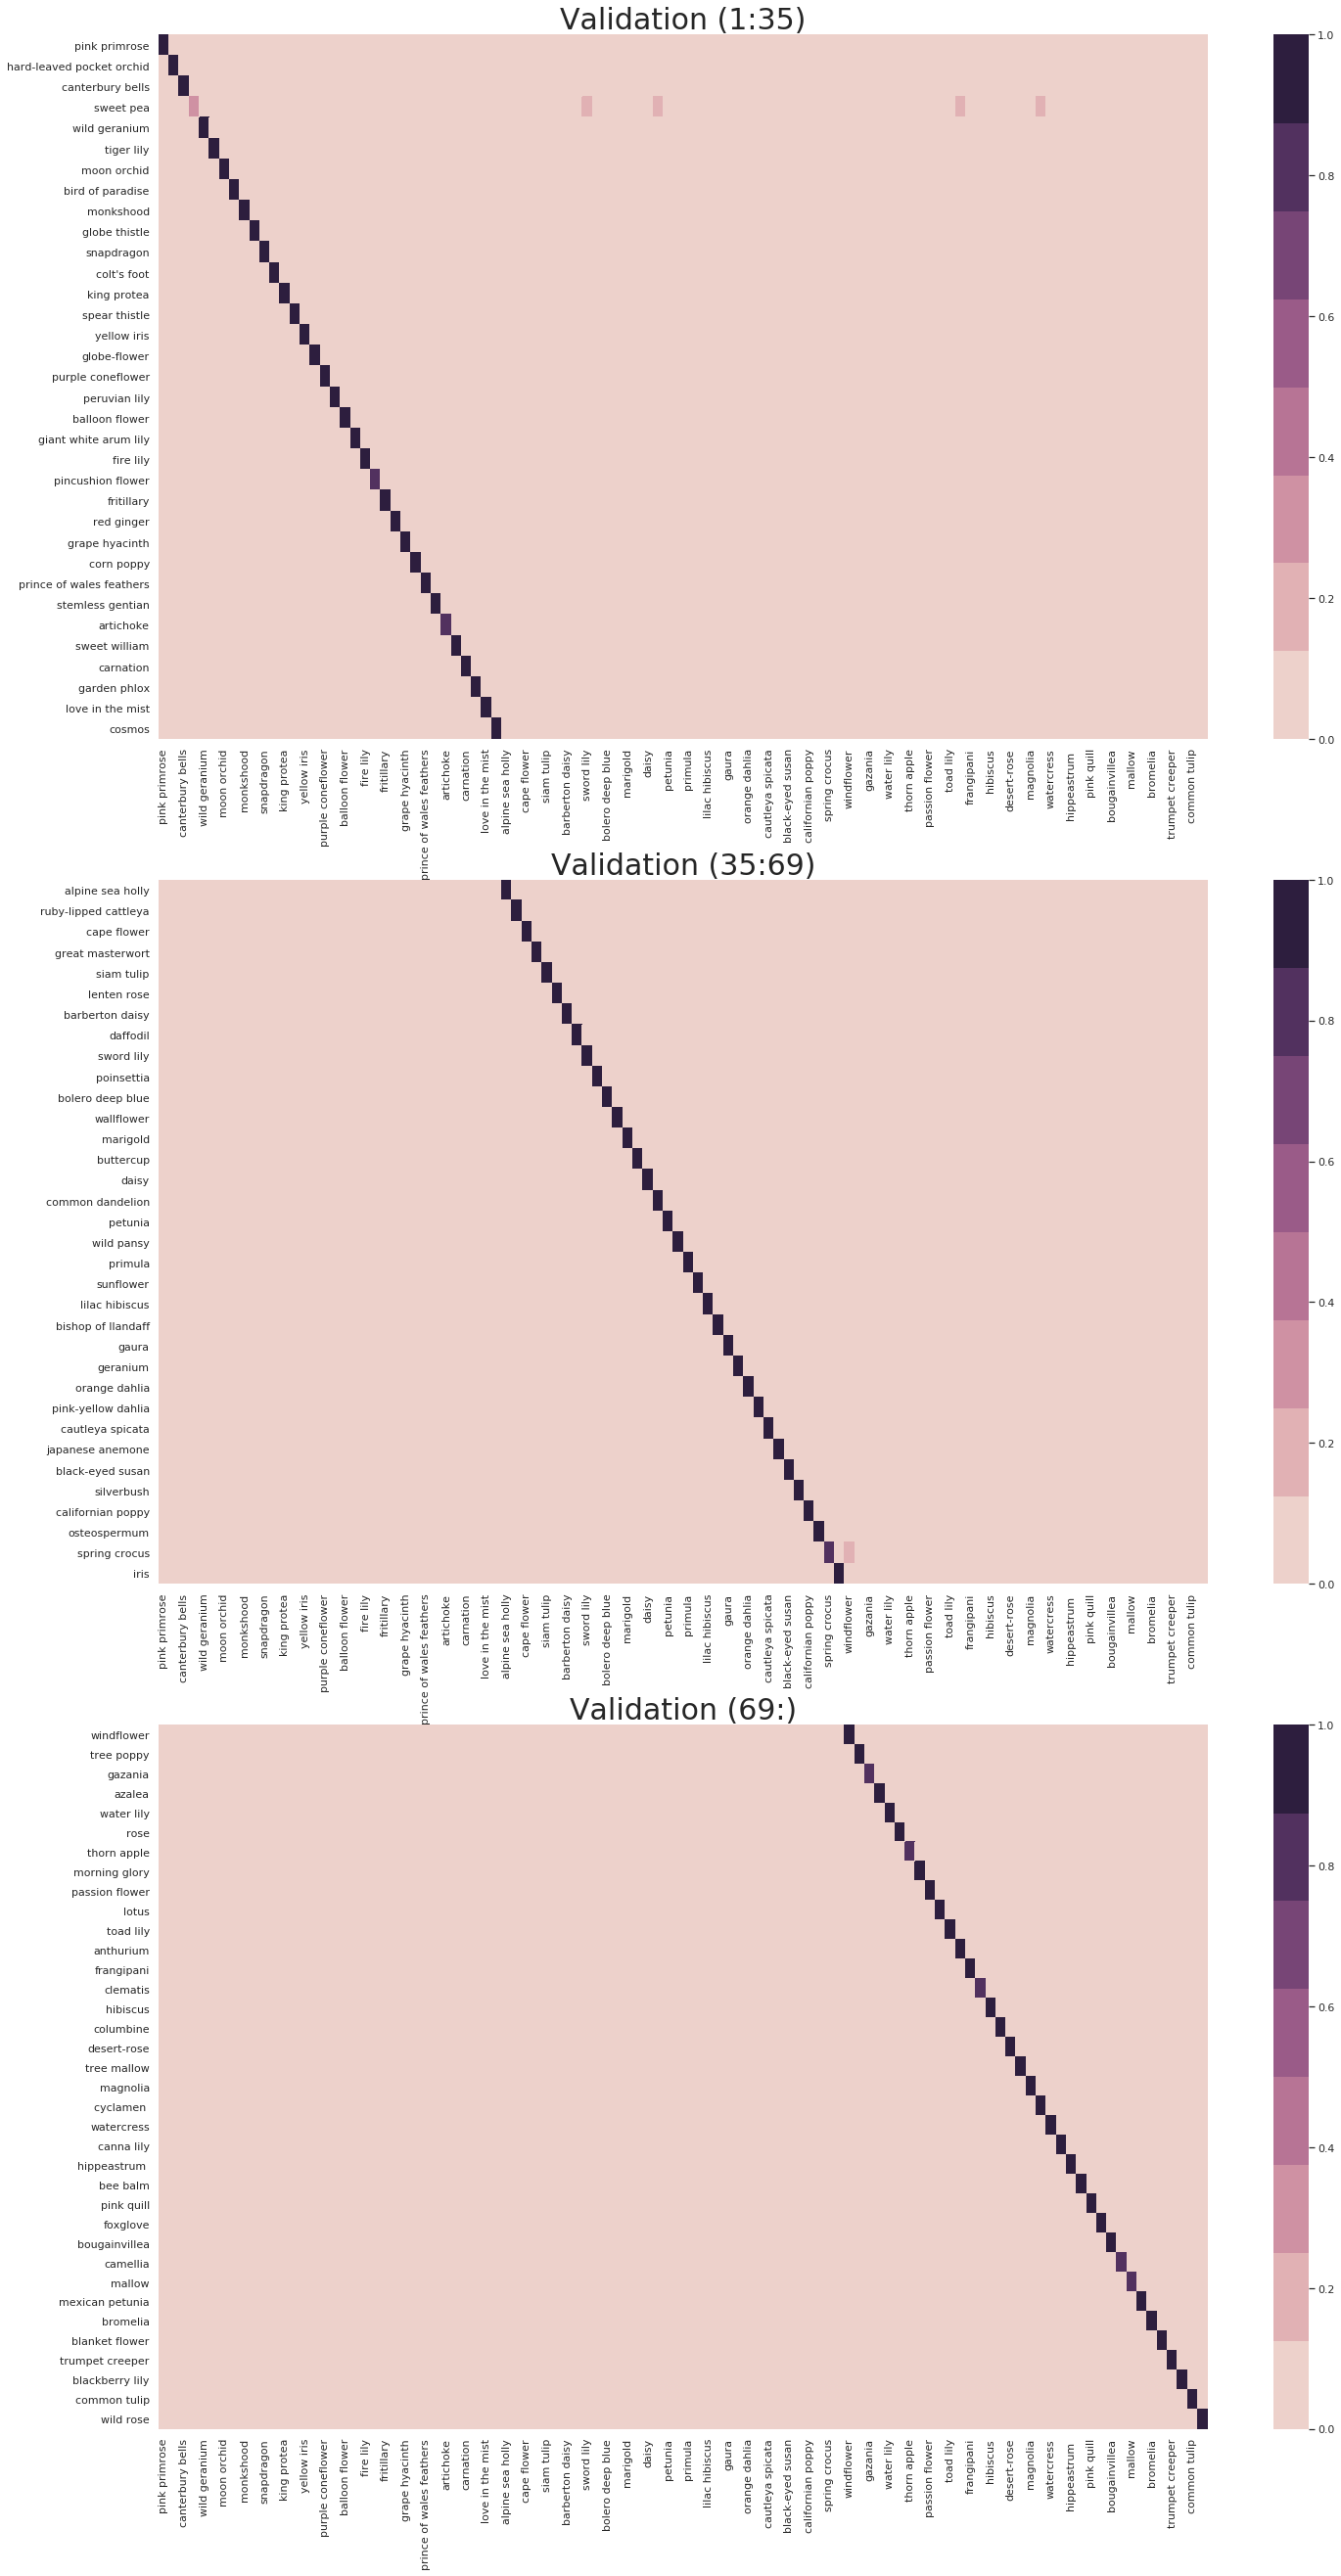

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 45))

valid_cfn_matrix = confusion_matrix(y_valid, valid_preds, labels=range(len(CLASSES)))
valid_cfn_matrix = (valid_cfn_matrix.T / valid_cfn_matrix.sum(axis=1)).T

valid_df_cm1 = pd.DataFrame(valid_cfn_matrix[:34], index=CLASSES[:34], columns=CLASSES)
valid_df_cm2 = pd.DataFrame(valid_cfn_matrix[34:68], index=CLASSES[34:68], columns=CLASSES)
valid_df_cm3 = pd.DataFrame(valid_cfn_matrix[68:], index=CLASSES[68:], columns=CLASSES)

sns.heatmap(valid_df_cm1, cmap=sns.cubehelix_palette(8), ax=ax1).set_title('Validation (1:35)', fontsize=30)
sns.heatmap(valid_df_cm2, cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Validation (35:69)', fontsize=30)
sns.heatmap(valid_df_cm3, cmap=sns.cubehelix_palette(8), ax=ax3).set_title('Validation (69:)', fontsize=30)
plt.show()

# Visualize predictions

## Train set

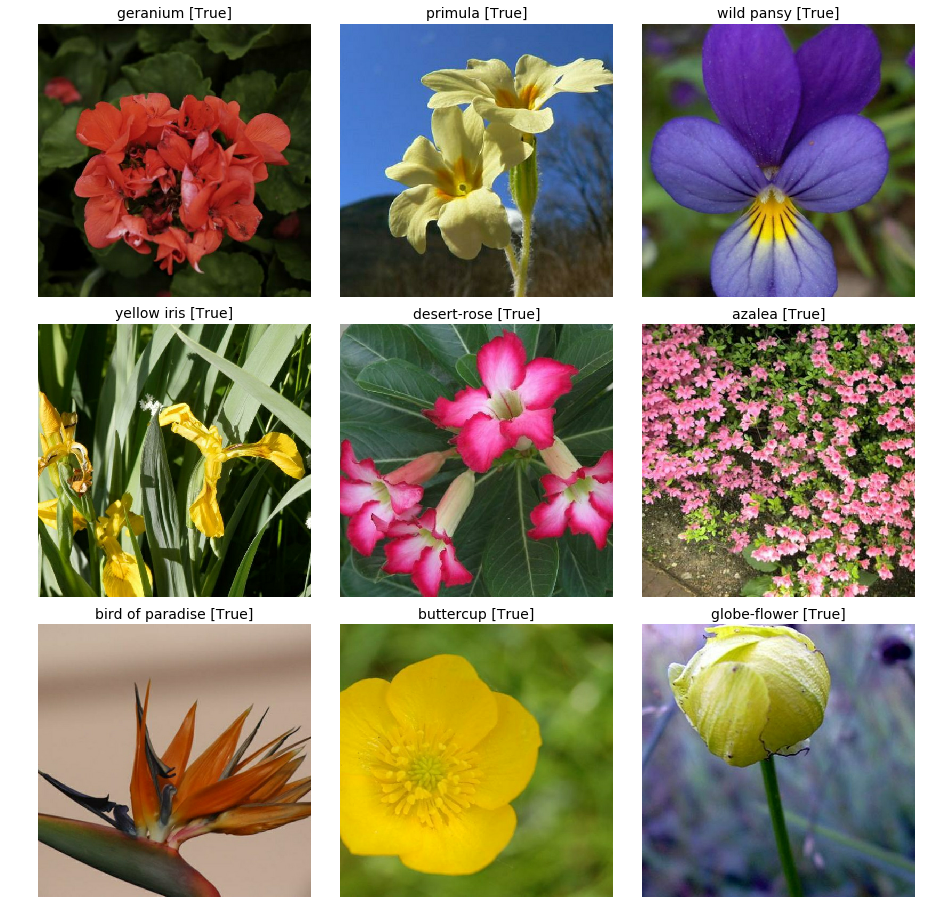

In [22]:
x_train_samp, y_train_samp = dataset_to_numpy_util(train_dataset, 9)
train_samp_preds = model.predict(x_train_samp, batch_size=9)
display_9_images_with_predictions(x_train_samp, train_samp_preds, y_train_samp)

## Validation set

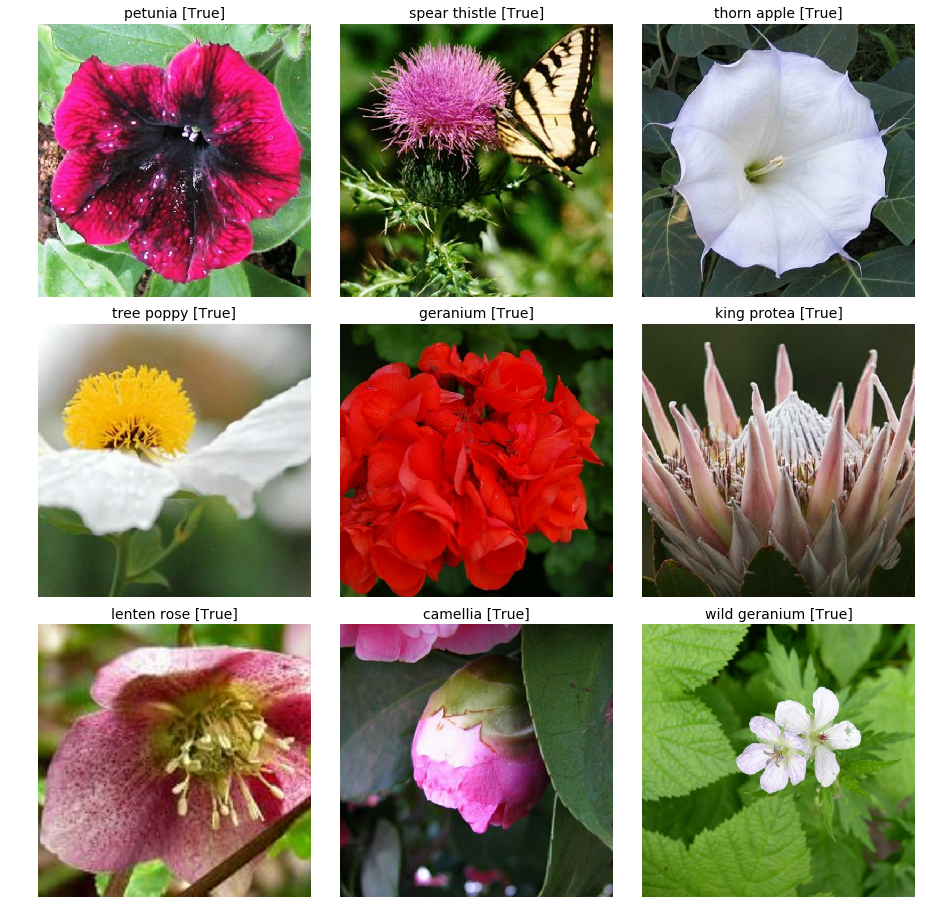

In [23]:
x_valid_samp, y_valid_samp = dataset_to_numpy_util(valid_dataset, 9)
valid_samp_preds = model.predict(x_valid_samp, batch_size=9)
display_9_images_with_predictions(x_valid_samp, valid_samp_preds, y_valid_samp)

# Test set predictions

In [24]:
x_test = test_dataset.map(lambda image, idnum: image)
test_preds = model.predict(x_test)
test_preds = np.argmax(test_preds, axis=-1)

In [25]:
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

submission = pd.DataFrame(test_ids, columns=['id'])
submission['label'] = test_preds
submission.to_csv('submission.csv', index=False)
display(submission.head(10))

id  label
0  252d840db     67
1  1c4736dea     28
2  c37a6f3e9     83
3  00e4f514e    103
4  59d1b6146     70
5  8d808a07b     53
6  aeb67eefb     52
7  53cfc6586     29
8  aaa580243     82
9  d907ca7c0     13